## Load Libraries

In [1]:
import pandas as pd
from pathlib import Path

# %pip install -q transformers sentence-transformers pandas
from sentence_transformers import SentenceTransformer, util
from scipy.stats import spearmanr
# Disable truncation of long strings in pandas output
pd.set_option('display.max_colwidth', None)


## Load Parquet files

In [2]:
import pandas as pd
import requests
from io import BytesIO

def load_parquet_from_url(url):
    """
    Downloads a Parquet file from a URL and loads it into a DataFrame.

    Parameters:
    - url (str): The URL to the Parquet file.

    Returns:
    - pd.DataFrame: The loaded DataFrame if successful, None otherwise.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises HTTPError if status is 4xx, 5xx
        file_stream = BytesIO(response.content)
        customer_reviews_df = pd.read_parquet(file_stream)
        print("File loaded successfully!")
        # display(customer_reviews_df.head())
        return customer_reviews_df
    except requests.exceptions.RequestException as e:
        print(f"Failed to download the file: {e}")
        return None
    except Exception as e:
        print(f"Failed to load the parquet file: {e}")
        return None

## Load unclassified dataset:

In [3]:
# from pathlib import Path

# load from local Parquet file
# file_path = Path("./Resources/philly_reviews_without_mood.parquet")
# Load the Parquet file
# customer_reviews_df = pd.read_parquet(file_path)

# Load parquet file
url = "https://github.com/tlockhart/project-3/releases/download/v2.0/philly_reviews_without_mood.parquet"
customer_reviews_df = load_parquet_from_url(url)


# Rename "text" column to "review" if needed
customer_reviews_df = customer_reviews_df.rename(columns={"text": "review"})

# Display the first few rows
display(customer_reviews_df.head(1))

File loaded successfully!


,review_id,user_id,business_id,review,business_name,address,city,categories,friends,review_stars,...,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,YpDx1X1OvnwUgdkHeZNvWw,OfhZlqYMrCVAhM-bt_cQug,J-ciDDEdIHMcChGIyKZnOg,Beautiful clean shop with knock your socks off Everything ...\nHomemade breakfast tarts and chicken pot pies .\nAll sweets looked well beyond beautiful and delish.\nI felt some of the items were a tad pricey considering the sizes being on a smaller size. But I know premium quality costs more .. \nIt's a great place for locals and worth a trip if traveling from center city etc .\nI found counter staff to be most friendly and engaging \nWill be back and certainly will recommend,Cake Life Bake Shop,1306 Frankford Ave,Philadelphia,"[Caterers, Cafes, Event Planning & Services, Food, Cupcakes, Bakeries, Restaurants, Desserts]","[rFANUt3nNW1auqcQTILUGQ, x1_sp_rHxZtI8VLX_IF5cw, 4My9e4rcNrAIIQEkNRqsBg, beN_tzswevSz73ur-O3zOA, _sZ6KsJyDRvaTBRZY9Welg, kTpsjDUhl9BlRl0FVuNreA]",4.0,...,0,0,0,0,0,6,0,0,0,0


## Classify review

In [ ]:
""" 
Deprecated code to classify review's mood (16 mins)
Required library Installations::
1. transformers: Hugging Face library for state-of-the-art NLP models
2. sentence-transformers: Simplified interface for computing sentence embeddings and semantic similarity
3. pandas: Data handling and manipulation library
4. SentenceTransformer: Loads pre-trained models for sentence embeddings.
5. util: Provides similarity utilities like cosine similarity.
"""
# Store Semantic Categories:
moods = [
    "adventurous", "comforting", "energizing", "romantic",
    "cozy", "festive", "indulgent", "refreshing"
]

"""
Use HugginFace sentence-transformers package and the 
all-MiniLM-L6-v2 model to classify review text based on 
the pytorch cosine similarity between text and mood embeddings, 
which uses angular similiarty between vectors
"""

"""
Initialize Sentence Transformer class with all_miniLM-L6-v2 model
to create mood and text embeddings (vector representation of text that 
captures meaning)
"""
model = SentenceTransformer("all-MiniLM-L6-v2") 
# Mood embedding , done only once
mood_embeddings = model.encode(moods, convert_to_tensor=True)

# Manually reviewed human scores
first_ten_human_scored_moods = [
    "indulgent", 
    "cozy", 
    "refreshing", 
    "indulgent", 
    "comforting",
    "cozy",
    "indulgent",
    "adventurous",
    "festive",
    "indulgent"]

# Create a mapping from mood to index
true_labels_mapping = {mood: idx for idx, mood in enumerate(moods)}

text_embedding = []
def assign_mood_and_score(text):
    """
    function calculates the pytorch cosine similarity between the model and review
    embeddings, by computing the cosine of the angle between two vectors.  Then
    used the argmax method to classify each review, by determine the mood with 
    the highest similarity.
    """
    # Checks if the input is a non-empty string.
    if not isinstance(text, str) or len(text.strip()) == 0:
        return "neutral"
    
    # Embed all customer reviews.
    # Note: SentenceTransformers models (based on BERT model) 
    # include tokenization inside the encode method.
    # text_embedding.append(model.encode(text, convert_to_tensor=True))
    text_tensor = model.encode(text, convert_to_tensor=True)
    
    """
    Compares the customer review embedding (a dense vector representation of meaning).
    against mood embeddings using pytorch cosine similarity
    """
    similarity_scores = util.pytorch_cos_sim(text_tensor, mood_embeddings)
    
    # Returns the mood with the highest similarity
    best_match = similarity_scores.argmax().item()
    
    # Get similarity scores as a list
    scores = similarity_scores[0].tolist()
    
    return moods[best_match], scores
#########################################
#  Add the classified moods to a new column called mood
results = customer_reviews_df["review"].apply(assign_mood_and_score)

## Seperate results
moods_predicted = []
similarity_scores_list = []

for mood, scores in results:
    moods_predicted.append(mood)
    similarity_scores_list.append(scores)

# Add predicted mood to original dataframe
customer_reviews_df["mood"] = moods_predicted

# Create a new dataframe for similarity scores
similarity_scores_df = pd.DataFrame(similarity_scores_list, columns=moods)
######################################
# Spearman calculations
spearman_scores = []
# display(len(first_ten_human_scored_moods))
for i in range(len(first_ten_human_scored_moods)):  
    predicted_scores = similarity_scores_df.loc[i, moods].values
    
    human_mood = first_ten_human_scored_moods[i]
    true_label_index = true_labels_mapping.get(human_mood)
    
    # Create one-hot ground truth vector
    ground_truth = [1 if j == true_label_index else 0 for j in range(len(moods))]
    
    spearman_corr, _ = spearmanr(predicted_scores, ground_truth)
    spearman_scores.append(spearman_corr)

# 8. Add Spearman scores back to the first 10 rows of your main DataFrame
customer_reviews_df.loc[:9, "spearman_correlation"] = spearman_scores

# 9. See results
print(customer_reviews_df[["review", "mood", "spearman_correlation"]].head(10))
##################################
review_scores_df = pd.concat([customer_reviews_df[["review", "mood", "spearman_correlation"]], similarity_scores_df], axis=1)

if "review" in review_scores_df.columns:
    review_scores_df["short_review"] = review_scores_df["review"].apply(
        lambda x: x[:50] + "..." if isinstance(x, str) and len(x) > 50 else x
    )

# Rename 'short_review' back to 'review'
review_scores_df = review_scores_df.rename(columns={"short_review": "review"})
review_scores_df = review_scores_df.drop(columns=["review"])

# Take your 10 human-scored moods then add None for all the remaining rows.
# Now the list length matches the DataFrame’s length
review_scores_df["human_scored_mood"] = first_ten_human_scored_moods + [None] * (len(review_scores_df) - len(first_ten_human_scored_moods))

# Print first 5 rows
print("*****Similarity_Scores_DF")
print(review_scores_df.head())

# Stored as Github Release: Save only similarity scores to a separate file
# scores_output_path = "./Resources/review_mood_similarity_scores.parquet"
# similarity_scores_df.to_parquet(scores_output_path, index=False)

# Stored as Github Release: Output the new dataset with mood labels
# output_path = "./Resources/philly_reviews_with_mood.parquet"
# customer_reviews_df.to_parquet(output_path, index=False)

# print(f"Saved labeled file to: {output_path}")

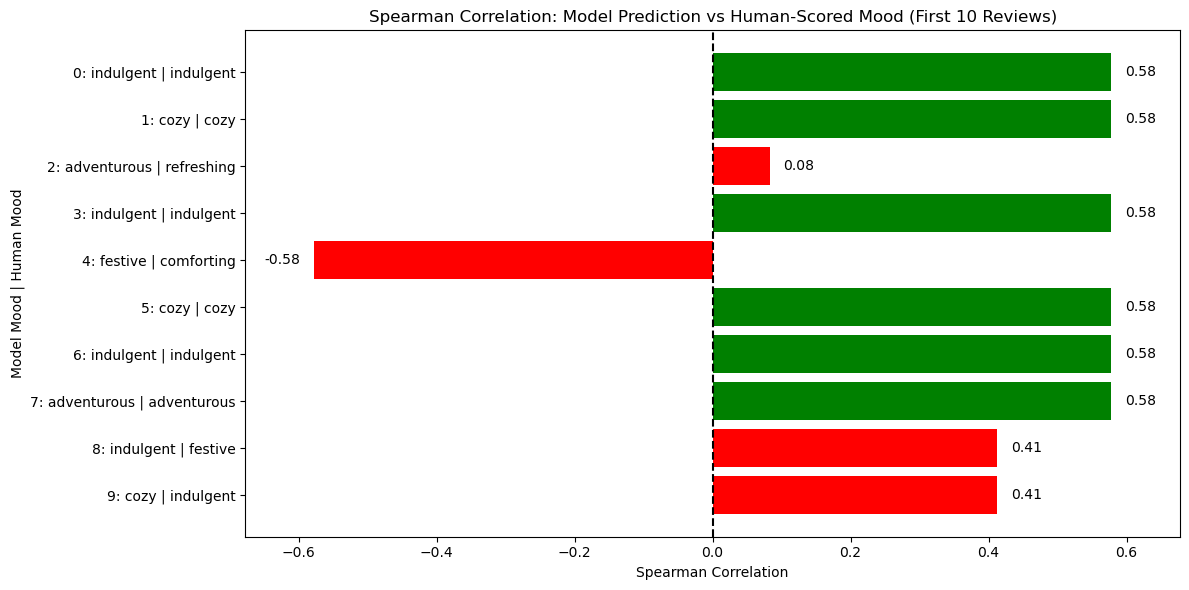

In [5]:
import matplotlib.pyplot as plt
import os
from pathlib import Path

# subset the first 10 rows and reverse the order
subset_df = review_scores_df.head(10).reset_index(drop=True)

# Create mood comparison with index
subset_df["mood_comparison"] = subset_df.index.astype(str) + ": " + subset_df["mood"] + " | " + subset_df["human_scored_mood"].fillna("None")

# THEN flip it for visualization
subset_df = subset_df[::-1].reset_index(drop=True)

chart_path = Path("./Resources/spearman_flipped.png")
os.makedirs(chart_path.parent, exist_ok=True)

# Set up the plot
plt.figure(figsize=(12, 6))

# Assign colors
colors = ['green' if model == human else 'red' for model, human in zip(subset_df["mood"], subset_df["human_scored_mood"])]

# Bar plot
bars = plt.barh(
    y=subset_df["mood_comparison"],
    width=subset_df["spearman_correlation"],
    color=colors
)

# Add a vertical line at 0 for reference
plt.axvline(x=0, color='black', linestyle='--')

# Set labels and title
plt.xlabel("Spearman Correlation")
plt.ylabel("Model Mood | Human Mood")
plt.title("Spearman Correlation: Model Prediction vs Human-Scored Mood (First 10 Reviews)")

# Add padding around the bars (adjust this as needed)
padding = 0.1  # space between bars and plot edges
max_width = subset_df["spearman_correlation"].abs().max() + padding
plt.xlim(-max_width, max_width)

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + (0.02 if width >= 0 else -0.02),  # slight padding to left/right based on sign
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        va="center",
        ha="left" if width >= 0 else "right"
    )

plt.tight_layout()
plt.savefig(chart_path, dpi=300, bbox_inches="tight")
plt.show()


In [6]:
print(subset_df[["mood", "human_scored_mood", "spearman_correlation"]])

          mood human_scored_mood  spearman_correlation
0         cozy         indulgent              0.412393
1    indulgent           festive              0.412393
2  adventurous       adventurous              0.577350
3    indulgent         indulgent              0.577350
4         cozy              cozy              0.577350
5      festive        comforting             -0.577350
6    indulgent         indulgent              0.577350
7  adventurous        refreshing              0.082479
8         cozy              cozy              0.577350
9    indulgent         indulgent              0.577350
